In the earlier file we dealt with data representing users accounts. The first few user accounts are (remember that this is not real data).

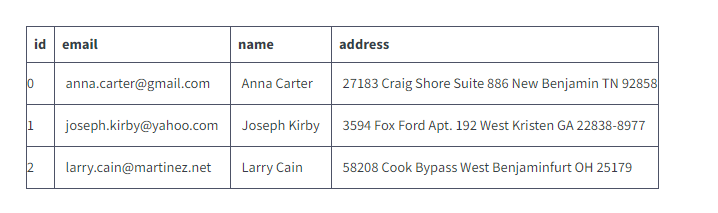

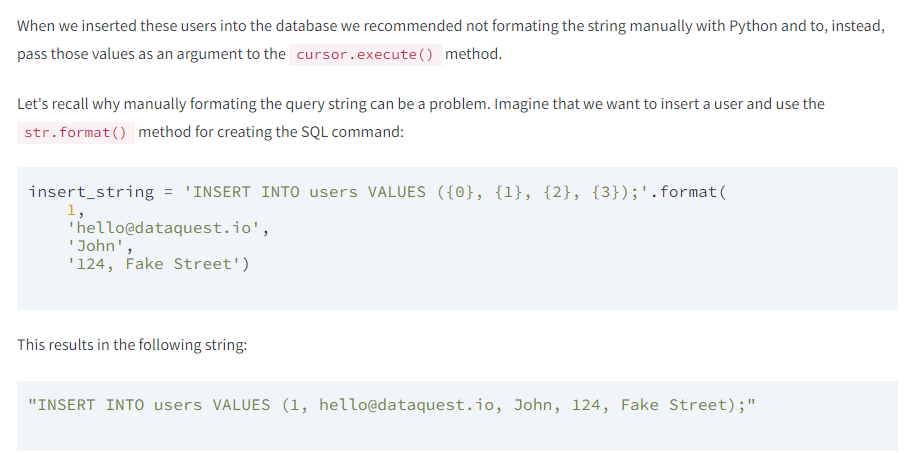

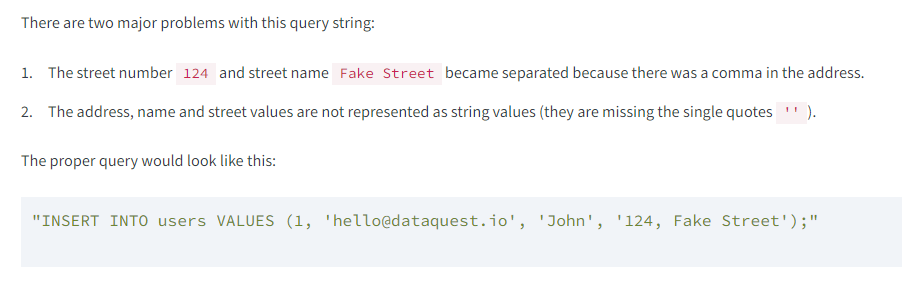

Executing the first query will cause a syntax error. We will see that this kind of formatting can lead to much bigger problems than an invalid SQL query.

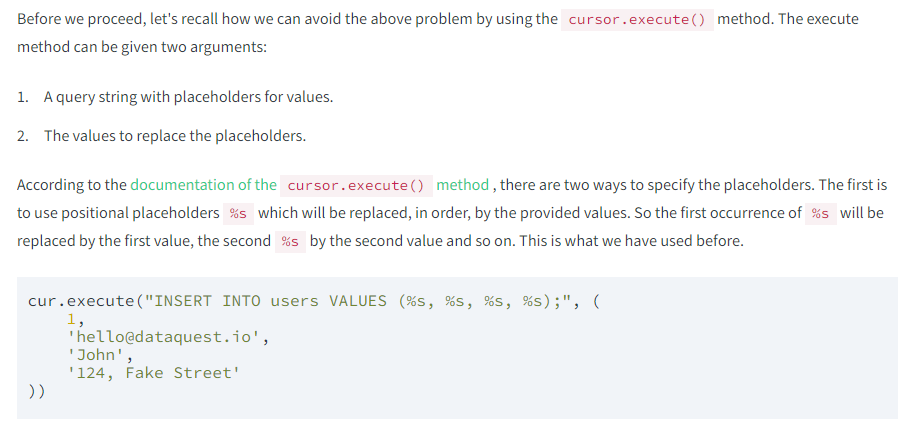

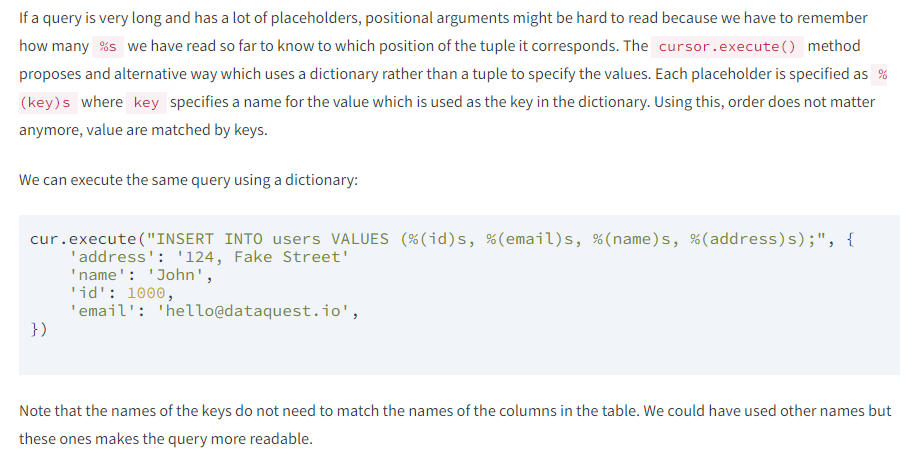

**Task**

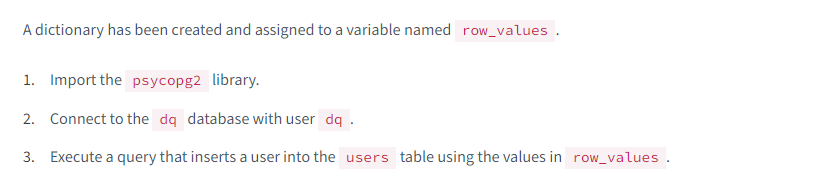

**Answer**

`row_values = { 
    'identifier': 1, 
    'mail': 'adam.smith@dataquest.io',
    'name': 'Adam Smith', 
    'address': '42 Fake Street'
}`

`import psycopg2
conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`cur.execute("INSERT INTO users VALUES (%(identifier)s, %(mail)s, %(name)s, %(address)s);", row_values)
conn.commit()
conn.close()`

Now that we have a better understanding of how we can pass values to the `cursor.execute()` method, let's continue understanding why formatting queries manually can be problematic.

Imagine that we are building a website and that somewhere it contains a text field where one can input a name of a user in order to obtain the email address of that user. This function could be implemented in Python as follows:

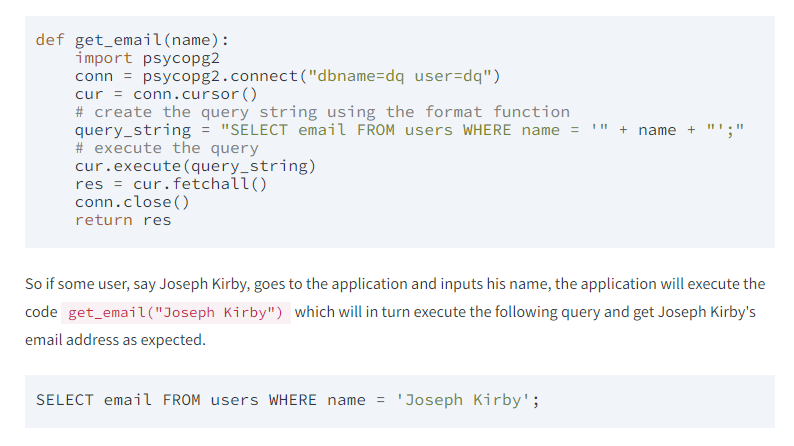

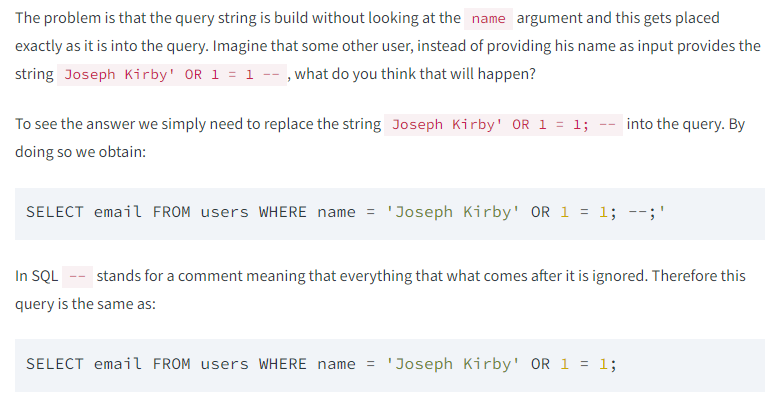

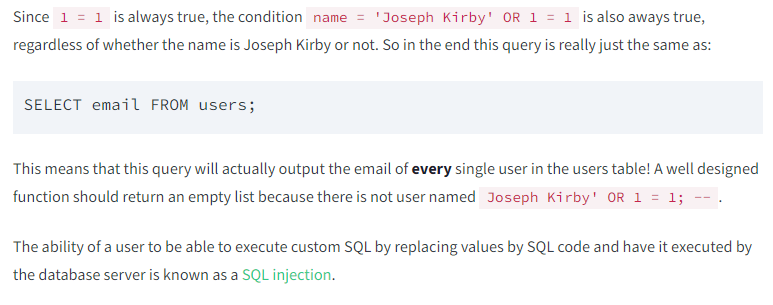

**Task**

*  Create a function `get_email()` that obtain the email address of **all** users in the database.
* Assign those email addresses to a variable named `all_emails`.

**Answer**

Above we were able to execute a custom SQL query by passing it as a input. With this we were able to obtain the list of all user emails with a single query.

We might say that this is not a big problem since this information was available anyway. We could have accessed it by making one query for each name in the database. However, we will see that we can actually access other columns. In particular, we will see how to obtain the home address of a given user rather than its email.

We can obtain the address of `Joseph Kirby` by issuing the query:

`SELECT address FROM users WHERE name = 'Joseph Kirby';`

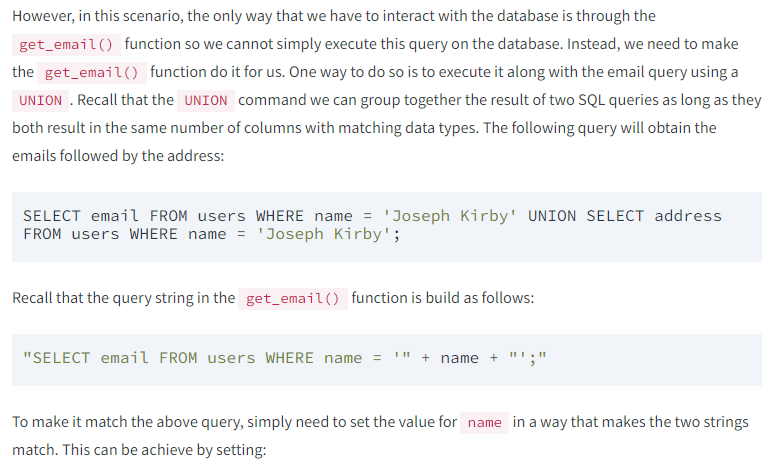

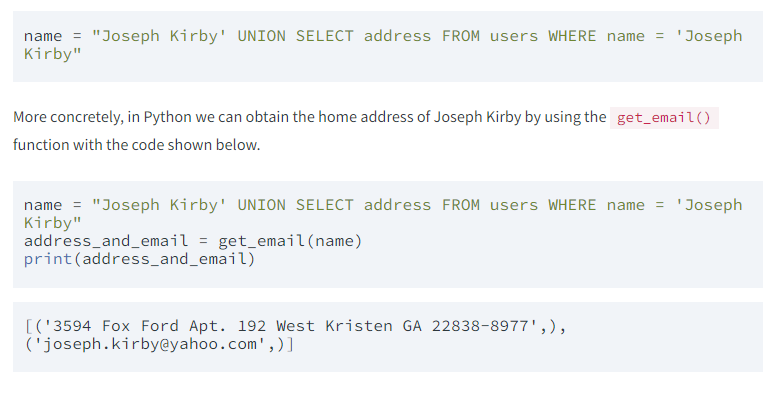

**Task**

Using the  `get_email()` function, obtain the address and email address of user `Larry Cain`.

**Answer**

`def get_email(name):
    import psycopg2
    conn = psycopg2.connect("dbname=dq user=dq")
    cur = conn.cursor()
    query_string = "SELECT email FROM users WHERE name = '" + name + "';"
    cur.execute(query_string)
    res = cur.fetchall()
    conn.close()
    return res`

`address_and_email = get_email("Larry Cain' UNION SELECT address FROM users WHERE name = 'Larry Cain")
print(address_and_email)`

As we saw above, manually formating the query strings from given input parameters can easily open the door for SQL injections where a user is able to execute a custom query by passing it as a parameter.

This problem is very common still nowadays on a lot of websites and web applications. Therefore, it is important to be aware of this so that we avoid doing the same mistakes if we are ever in a position where we have to build an interface for users to query a database. The above example is just a few steps away from even more devastating queries such as obtaining user passwords.

So what can we do to overcome this?

Using the `psycopg2` library, we can properly parse the values by giving them as the second argument of the `cursor.execute()` method. This will ensure that whichever values are passed, they will be interpreted as values in the query and never escape this to build a more complex query.

The behaviour that we want is that when we pass a value like

`name = "Joseph Kirby' UNION SELECT address FROM users WHERE name = 'Joseph Kirby"`

is for the database to check whether there is a person named

`Joseph Kirby' UNION SELECT address FROM users WHERE name = 'Joseph Kirby`

which of course there isn't. All characters in the string should be interpreted as part of the value that we are looking for, not as actual SQL code.

So far, we have only passed values to the `cursor.execute()` method when using `INSERT` commands. However, it works for any kind of command. In this example, we can use it with `SELECT` as follows:

`cur.execute("SELECT email FROM users WHERE name = %s;", (name,))`

As we explained before, the execute method will go over all occurrences of `%s` and replace them by the values given as a second argument. These values are automatically formated in this process to make them into a valid query. For example, strings are added single quotes around them.

**Task**

* Rename `get_email()` function to `get_email_fixed`.
* Fix the line containing `cur.execute` line as we describe above by using placeholders and an tuple argument for the values.

**Answer**

Above we saw how we can use the `cursor.execute()` method from the `psycopg2` library in order to help avoid SQL injections. However there is a direct way to do it in SQL using the [`PREPARE` statement](https://www.postgresql.org/docs/12/sql-prepare.html) to form a **prepared statement**.

For example, we can prepare a statement for inserting a user as follows:

`PREPARE insert_user(integer, text, text, text) AS
    INSERT INTO users VALUES ($1, $2, $3, $4);`

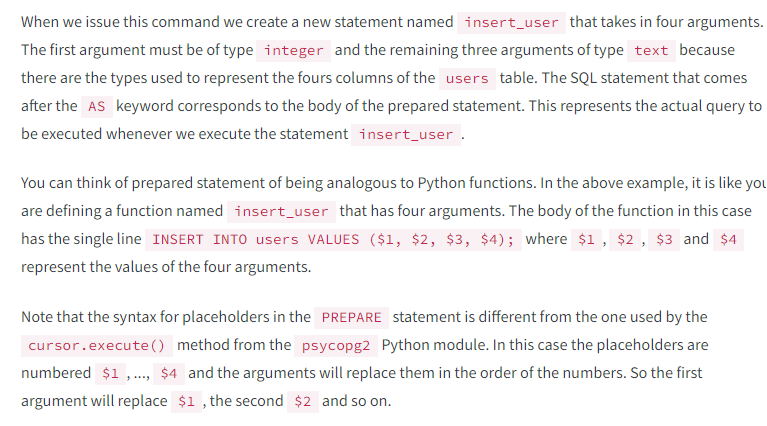

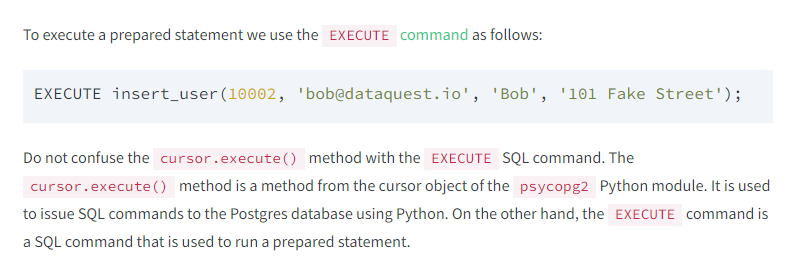

In Postgres we can prepare and run a prepared statement as follows:

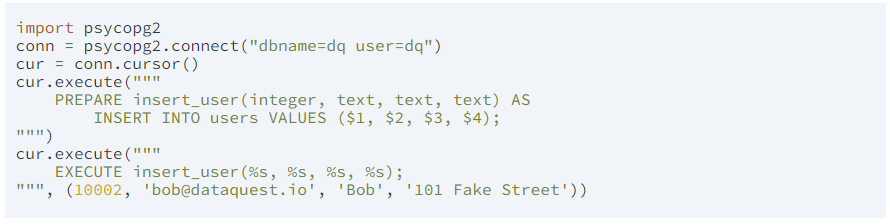

Even though prepared statements protect us from SQL injections, we recommend to pass the values using the execute method as it makes it easier to avoid syntax problems. For instance, the previous problem of having a comma in the address will still cause a error when using prepared statements.

It is important for us to learn prepared statement because they are not specific to **Postgres** and exist in others SQL servers such as **MySQL**. In this way we will be able to leverage what we have learned in a wide range of situations.

Let's create and execute a prepared statement. Note that, using `psycopg2`, both queries above are executed using the` cursor.execute()` method, like any other query.

**Task**

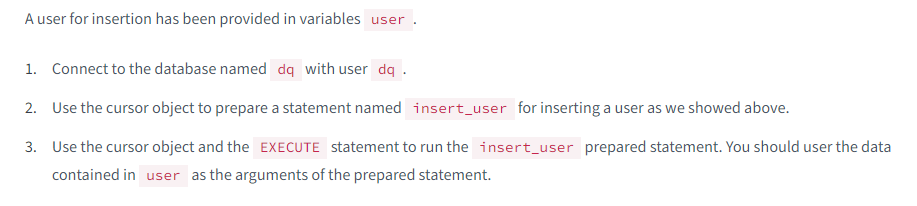

**Answer**

`import psycopg2`

`user = (10003, 'alice@dataquest.io', 'Alice', '102, Fake Street')`

`conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`cur.execute("""
    PREPARE insert_user(integer, text, text, text) AS
    INSERT INTO users VALUES ($1, $2, $3, $4);
""")`

`cur.execute("""
    EXECUTE insert_user(%s, %s, %s, %s);
""", user)`

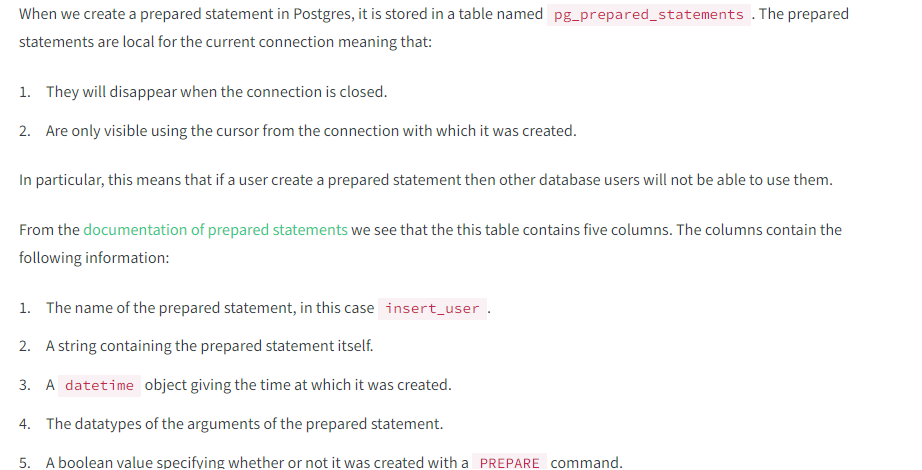

This table is mostly useful for us to be able to see the current prepared statements. We believe that in general it is important to learn **Postgres internal tables** to be able to get a deeper understanding of how it works.

Let's create a prepared statement and inspect the `pg_prepared_statements` table to check that it indeed appears there.

We will be preparing the same query that we used before for getting the email address of a given user:

`SELECT email FROM users WHERE name = 'Some name';`

**Task**

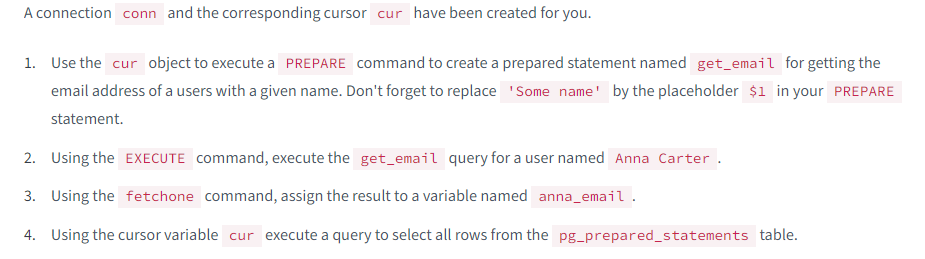

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=dq user=dq")
cur = conn.cursor()`

`cur.execute("""
    PREPARE get_email(text) AS
        SELECT email FROM users WHERE name = $1;""")`

`cur.execute("""
    EXECUTE get_email(%s);
""", ('Anna Carter',))`

`anna_email = cur.fetchone()`

`cur.execute("""
    SELECT * FROM pg_prepared_statements;
""")`

`print(cur.fetchall())`

Prepared statements main purpose is to avoid SQL injections. However they can sometimes accelerate queries.

So far we have focused more on the SQL injections aspect of prepared statements. Now we are going to analyze the speed gained from using prepared statement we performing the same query a lot of times.

When we perform a SQL query, in a high level the following steps occur:

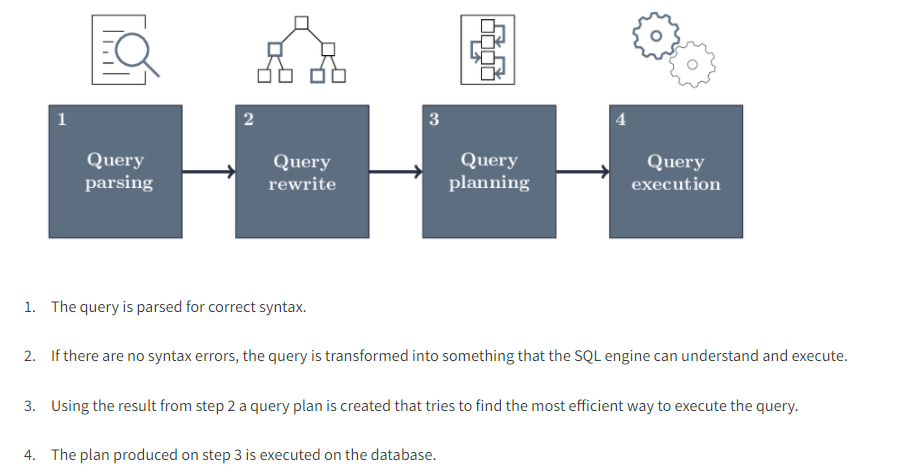

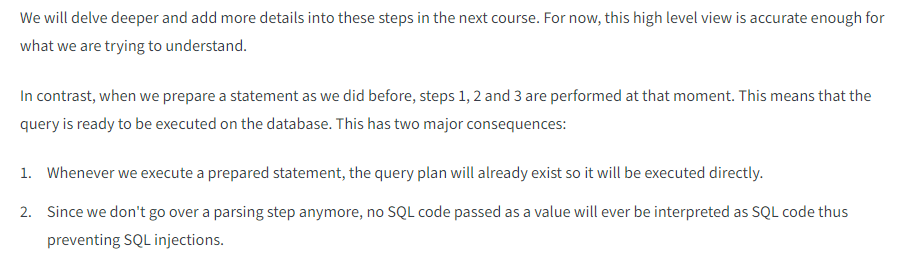

Let's compare the runtime of inserting all users with and without prepared statements. We wrote a function for inserting with a prepared statement and one without. 

To time a python function we can use the [`timeit` module](https://docs.python.org/3.8/library/timeit.html). This module has a lot of options that we can read in the documentation.

Here, we will only use it to calculate and compare the runtime of both provided function like so:

`import timeit
runtime = timeit.timeit(function_name, number=1)`

In the above snippet `function_name` is the name of the function that we want to time and `number` is the number of times that we want to execute the function. 

In general, to get an estimation of the runtime we run the function several times and compute the average runtime. However in this example the runtime is quite high so we will run it only once.

**Task**

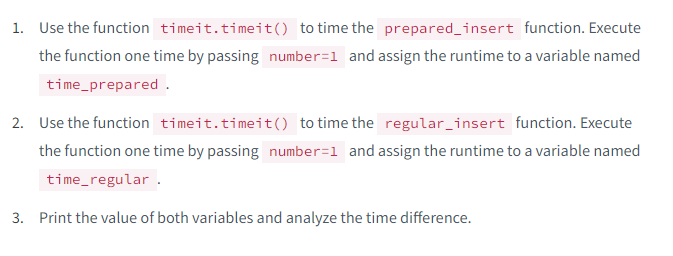

**Answer**

`import timeit
import psycopg2
import csv`

`# function that inserts all users using a prepared statement`

`def prepared_insert():
    conn = psycopg2.connect("dbname=dq user=dq")
    cur = conn.cursor()           
    cur.execute("""
        PREPARE insert_user(integer, text, text, text) AS
        INSERT INTO users VALUES ($1, $2, $3, $4)
    """)
    for user in users:
        cur.execute("EXECUTE insert_user(%s, %s, %s, %s)", user)
    conn.close()`

`# function that insert all users using a new INSERT query for each user`

`def regular_insert():
    conn = psycopg2.connect("dbname=dq user=dq")
    cur = conn.cursor()           
    for user in users:
        cur.execute("""
            INSERT INTO users VALUES (%s, %s, %s, %s)
        """, user)
    conn.close()`

`# read the users into a list`

`users = [ ]
with open('user_accounts.csv', 'r') as file:
    next(file) # skip csv header
    reader = csv.reader(file)
    for row in reader:
        users.append(row)`
        

`time_prepared = timeit.timeit(prepared_insert, number=1)
time_regular = timeit.timeit(regular_insert, number=1)
print(time_prepared)
print(time_regular)`

In this file, we learned about:

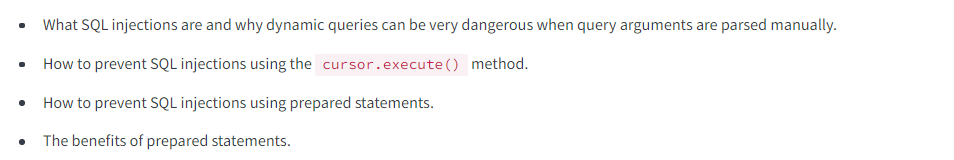

In the next file we are going learn about other ways to load data from CSV file into Postgres tables and also how to save a database table into CSV files.